# 卷积神经网络识别Fashion-MNIST

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST

## 图像数据准备

In [2]:
# 使用FashionMNIST数据，准备训练数据集
train_data = FashionMNIST(
    root = './data/FashionMNIST/',
    train = True,
    transform = transforms.ToTensor(),
    download = False,
)

# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = False,     # 不打乱，表示加载器中每个batch使用的样本都是固定的，这样有利于在训练模型时根据迭代的次数将其切分为训练集和验证集
    num_workers = 2,
)

# 计算train_loader有多少个epoch
print("train_loader的batch数量：",len(train_loader))

train_loader的batch数量： 938


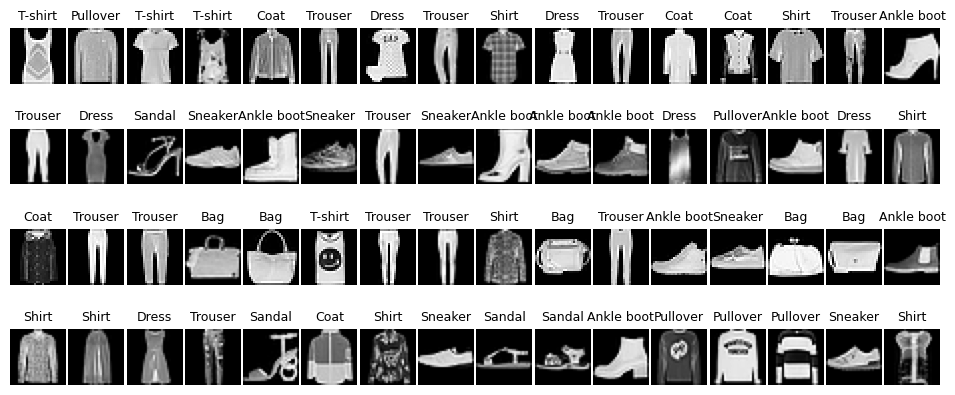

In [3]:
# 获得一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break
        
# 可视化一个batch的图像
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
class_label[0] = 'T-shirt'

plt.figure(figsize=(12, 5))
for ii in np.arange(len(batch_y)):
    plt.subplot(4, 16, ii+1)
    plt.imshow(batch_x[ii,:,:],cmap=plt.cm.gray)
    plt.title(class_label[batch_y[ii]], size=9)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.05)

In [4]:
# 对测试集进行处理
test_data = FashionMNIST(
    root = './data/FashionMNIST/',
    train = False,
    download = False
)

# 为数据添加一个通道纬度，并且取值范围缩放到0到1之间
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)
test_data_y = test_data.targets

print('test_data_x.shape:', test_data_x.shape)
print('test_data_y.shape:', test_data_y.shape)

test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


## 卷积神经网络的搭建

In [5]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,   # 输入的feature map
                out_channels=16, # 输出的feature map
                kernel_size=3,   # 卷积核尺寸
                stride=1,        # 卷积核步长
                padding=1,       # 进行填充
            ),                  # 卷积后，(1*28*28) -> (16*28*28)
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,    # 平均值池化层，使用2*2
                stride=2,        # 池化步长
            ),                   # 池化后，(16*28*28) -> (16*14*14)
        )
        
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,   # 输入的feature map
                out_channels=32, # 输出的feature map
                kernel_size=3,   # 卷积核尺寸
                stride=1,        # 卷积核步长
                padding=0,       # 进行填充
            ),                  # 卷积后，(16*14*14) -> (32*12*12)
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,    # 平均值池化层，使用2*2
                stride=2,        # 池化步长
            ),                   # 池化后，(32*12*12) -> (32*6*6)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32*6*6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    # 定义网络的前向传播路径
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图层
        output = self.classifier(x)
        return output

In [6]:
# 输出网络结构
myconvnet = MyConvNet()
print(myconvnet)

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 卷积神经网络训练与预测

In [7]:
# 定义网络的训练过程函数
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs=25):
    """
    model：网络模型    traindataloader：训练数据集，会切分为训练集和验证集    
    train_rate：训练集batchsize百分比    criterion：损失函数
    optimizer：优化方法    num_epochs：训练的轮数     
    """
    
    # 计算训练使用的batch数量
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    
    # 复制模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        # 每个epoch有两个训练阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step, (b_x, b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train() # 设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab==b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval() # 设置模型为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab==b_y.data)
                val_num += b_x.size(0)
        
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        
        print('{} Train Loss: {:.4f}    Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print('{} Val Loss: {:.4f}    Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
        
        # 拷贝模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_use = time.time() - since
        print('Train and val complete in {:.0f}m  {:.0f}s'.format(time_use // 60, time_use % 60))
        
    # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data = {
            "epoch":range(num_epochs),
            "train_loss_all": train_loss_all,
            "val_loss_all": val_loss_all,
            "train_acc_all": train_acc_all,
            "val_acc_all": val_acc_all
        }
    )
    
    return model, train_process

In [8]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
myconvnet, train_process = train_model(
    myconvnet, train_loader, 0.8, criterion, optimizer, num_epochs=25
)

Epoch0/24
----------
0 Train Loss: 0.7729    Train Acc: 0.7163
0 Val Loss: 0.5568    Val Acc: 0.7803
Train and val complete in 0m  18s
Epoch1/24
----------
1 Train Loss: 0.5199    Train Acc: 0.8054
1 Val Loss: 0.4742    Val Acc: 0.8227
Train and val complete in 0m  37s
Epoch2/24
----------
2 Train Loss: 0.4564    Train Acc: 0.8334
2 Val Loss: 0.4344    Val Acc: 0.8412
Train and val complete in 0m  57s
Epoch3/24
----------
3 Train Loss: 0.4165    Train Acc: 0.8488
3 Val Loss: 0.4124    Val Acc: 0.8483
Train and val complete in 1m  17s
Epoch4/24
----------
4 Train Loss: 0.3885    Train Acc: 0.8578
4 Val Loss: 0.3946    Val Acc: 0.8534
Train and val complete in 1m  36s
Epoch5/24
----------
5 Train Loss: 0.3661    Train Acc: 0.8660
5 Val Loss: 0.3774    Val Acc: 0.8602
Train and val complete in 1m  56s
Epoch6/24
----------
6 Train Loss: 0.3479    Train Acc: 0.8721
6 Val Loss: 0.3613    Val Acc: 0.8676
Train and val complete in 2m  15s
Epoch7/24
----------
7 Train Loss: 0.3319    Train Acc:

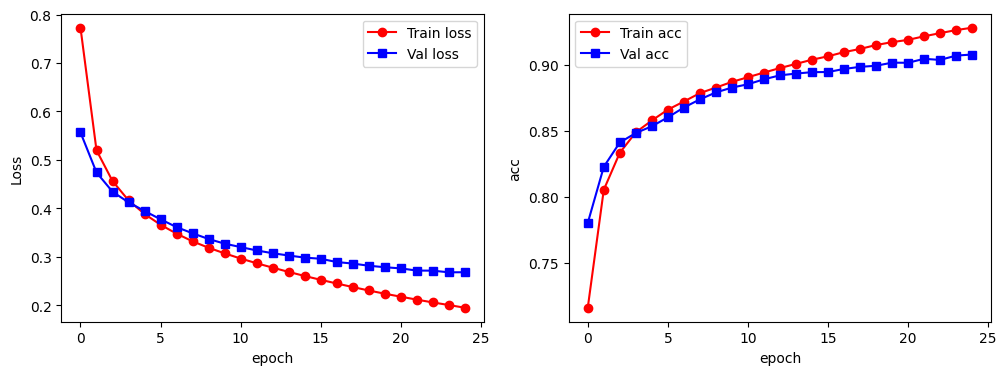

In [9]:
# 可视化训练过程中
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label="Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label="Train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label="Val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")

plt.show()

In [10]:
# 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)
print("在测试集上的预测精准度为：",acc)

在测试集上的预测精准度为： 0.899


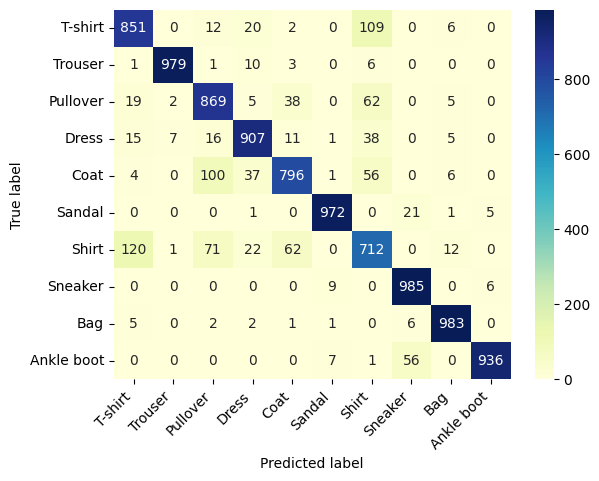

In [11]:
# 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y, pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha="right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha="right")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 空洞卷积神经网络的搭建

In [12]:
class MyConvdilaNet(nn.Module):
    def __init__(self):
        super(MyConvdilaNet, self).__init__()
        
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,   # 输入的feature map
                out_channels=16, # 输出的feature map
                kernel_size=3,   # 卷积核尺寸
                stride=1,        # 卷积核步长
                padding=1,       # 进行填充
                dilation=2,      # 使用空洞卷积
            ),                  # 卷积后，(1*28*28) -> (16*26*26)
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,    # 平均值池化层，使用2*2
                stride=2,        # 池化步长
            ),                   # 池化后，(16*26*26) -> (16*13*13)
        )
        
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,   # 输入的feature map
                out_channels=32, # 输出的feature map
                kernel_size=3,   # 卷积核尺寸
                stride=1,        # 卷积核步长
                padding=0,       # 进行填充
                dilation=2,
            ),                  # 卷积后，(16*13*13) -> (32*9*9)
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,    # 平均值池化层，使用2*2
                stride=2,        # 池化步长
            ),                   # 池化后，(32*9*9) -> (32*4*4)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    # 定义网络的前向传播路径
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图层
        output = self.classifier(x)
        return output

In [13]:
# 输出网络结构
myconvdilanet = MyConvdilaNet()
print(myconvdilanet)

MyConvdilaNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 空洞卷积神经网络训练与预测

In [14]:
# 对模型进行训练
# 对模型进行训练
optimizer = torch.optim.Adam(myconvdilanet.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

myconvdilanet, train_process = train_model(
    myconvdilanet, train_loader, 0.8, criterion, optimizer, num_epochs=25
)

Epoch0/24
----------
0 Train Loss: 0.9044    Train Acc: 0.6687
0 Val Loss: 0.6585    Val Acc: 0.7409
Train and val complete in 0m  13s
Epoch1/24
----------
1 Train Loss: 0.6287    Train Acc: 0.7581
1 Val Loss: 0.5804    Val Acc: 0.7760
Train and val complete in 0m  27s
Epoch2/24
----------
2 Train Loss: 0.5591    Train Acc: 0.7873
2 Val Loss: 0.5311    Val Acc: 0.8011
Train and val complete in 0m  42s
Epoch3/24
----------
3 Train Loss: 0.5131    Train Acc: 0.8061
3 Val Loss: 0.4976    Val Acc: 0.8161
Train and val complete in 0m  56s
Epoch4/24
----------
4 Train Loss: 0.4788    Train Acc: 0.8217
4 Val Loss: 0.4714    Val Acc: 0.8245
Train and val complete in 1m  10s
Epoch5/24
----------
5 Train Loss: 0.4514    Train Acc: 0.8330
5 Val Loss: 0.4502    Val Acc: 0.8355
Train and val complete in 1m  24s
Epoch6/24
----------
6 Train Loss: 0.4291    Train Acc: 0.8411
6 Val Loss: 0.4296    Val Acc: 0.8431
Train and val complete in 1m  39s
Epoch7/24
----------
7 Train Loss: 0.4094    Train Acc:

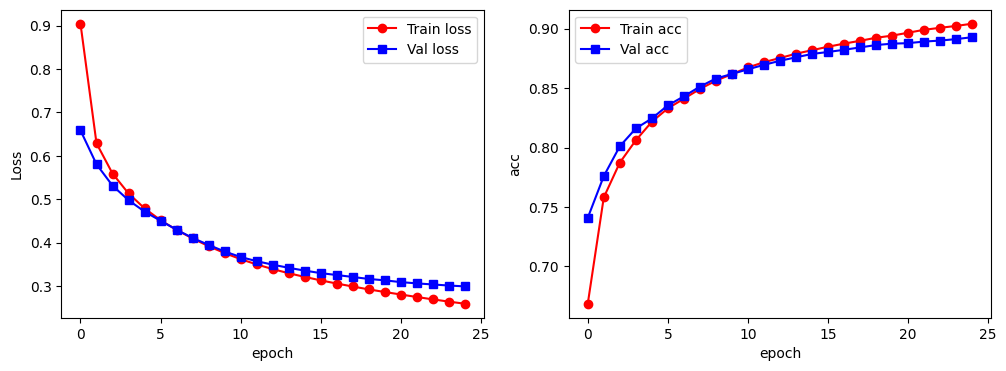

In [15]:
# 可视化模型训练过程中的精度和损失函数
# 可视化训练过程中
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label="Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label="Train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label="Val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")

plt.show()

In [16]:
# 对测试集进行预测，并可视化预测效果
myconvdilanet.eval()
output = myconvdilanet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)
print("在测试集上的预测精准度为：",acc)

在测试集上的预测精准度为： 0.888


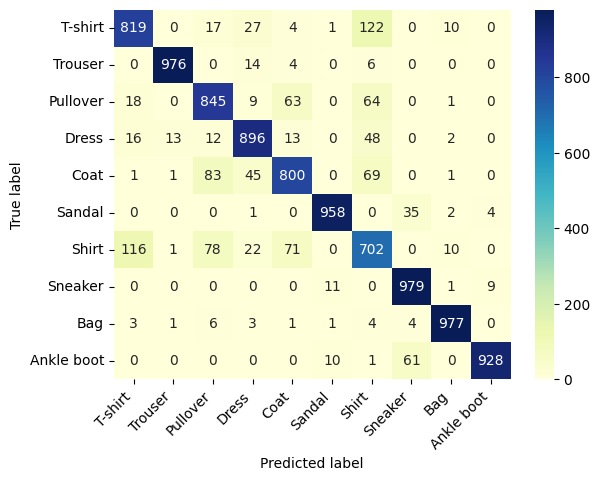

In [17]:
# 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y, pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha="right")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha="right")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 对预训练好的卷积网络微调

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.utils.data as Data
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

## 微调预训练的VGG16网络

In [4]:
# 导入预训练好的VGG16网络
vgg16 = models.vgg16(pretrained=True)

# 获取VGG16的特征提取层
vgg = vgg16.features

# 将VGG16的特征提取层参数冻结，不对其进行更新
for param in vgg.parameters():
    param.requires_grad_(False)

D:\Anaconda\envs\pytorch2.0\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch2.0\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 使用VGG16的特征提取层+新的全连接层组成新的网络
class MyVggModel(nn.Module):
    def __init__(self):
        super(MyVggModel, self).__init__()
        
        # 预训练的VGG16的特征提取层
        self.vgg = vgg
        
        # 添加新的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )
        
    # 定义网络的前向传播路径
    def forward(self, x):
        x = self.vgg(x)
        x = x.view(x.size(0), -1)
        output = self.classifier(x)
        return output

In [6]:
# 输出网络结构
Myvggc = MyVggModel()
print(Myvggc)

MyVggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

## 准备新网络需要的数据

In [7]:
# 使用10类猴子的数据集，对训练集预处理
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),   # 随即长宽比裁剪为224*224
    transforms.RandomHorizontalFlip(),   # 依概率p=0.5水平翻转
    transforms.ToTensor(),               # 转化为张量并归一化至[0-1]
    # 图像标准化处理
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 对验证集的预处理
val_data_transforms = transforms.Compose([
    transforms.Resize(256),   # 重置图像分辨率
    transforms.CenterCrop(224),   # 依据给定的size从中心裁剪
    transforms.ToTensor(),               # 转化为张量并归一化至[0-1]
    # 图像标准化处理
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# 读取训练集图像
train_data_dir = './data/10-monkeys-species/training/training/'
train_data = ImageFolder(train_data_dir, transform=train_data_transforms)
train_data_loader = Data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)

# 读取验证集
val_data_dir = './data/10-monkeys-species/validation/validation/'
val_data = ImageFolder(val_data_dir, transform=val_data_transforms)
val_data_loader = Data.DataLoader(val_data, batch_size=32, shuffle=True, num_workers=2)

print("训练集样本数：", len(train_data.targets))
print("验证集样本数：", len(val_data.targets))

训练集样本数： 1097
验证集样本数： 272


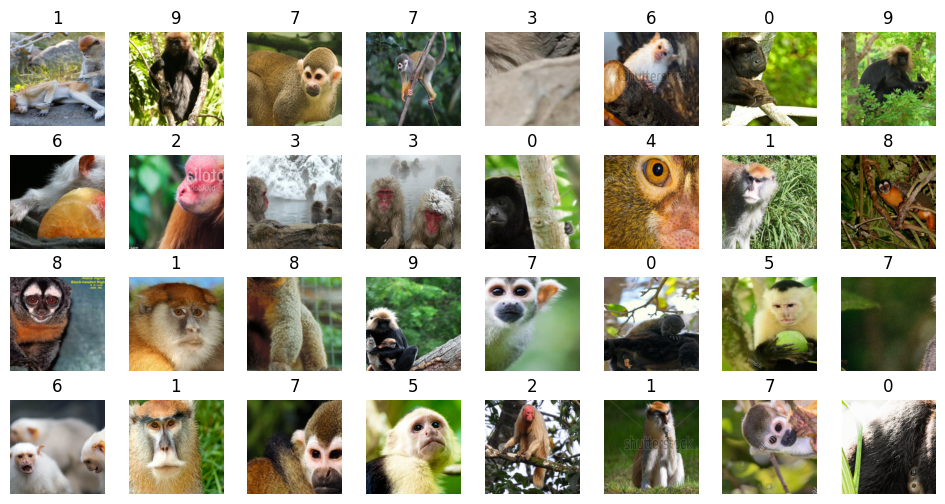

In [9]:
# 获取一个batch的数据
for step, (b_x, b_y) in enumerate(train_data_loader):
    if step > 0:
        break
        
# 可视化训练集其中一个batch的图像
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(12, 6))

for ii in np.arange(len(b_y)):
    plt.subplot(4, 8, ii+1)
    image = b_x[ii, :, :, :].numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(b_y[ii].data.numpy())
    plt.axis("off")
    
plt.subplots_adjust(hspace=0.3)

## 微调网络的训练和预测

In [10]:
# 定义优化器
optimizer = torch.optim.Adam(Myvggc.parameters(), lr=0.003)
loss_func = nn.CrossEntropyLoss()

# 记录训练过程的指标
history1 = hl.History()

# 使用Canvas进行可视化
canvas1 = hl.Canvas()

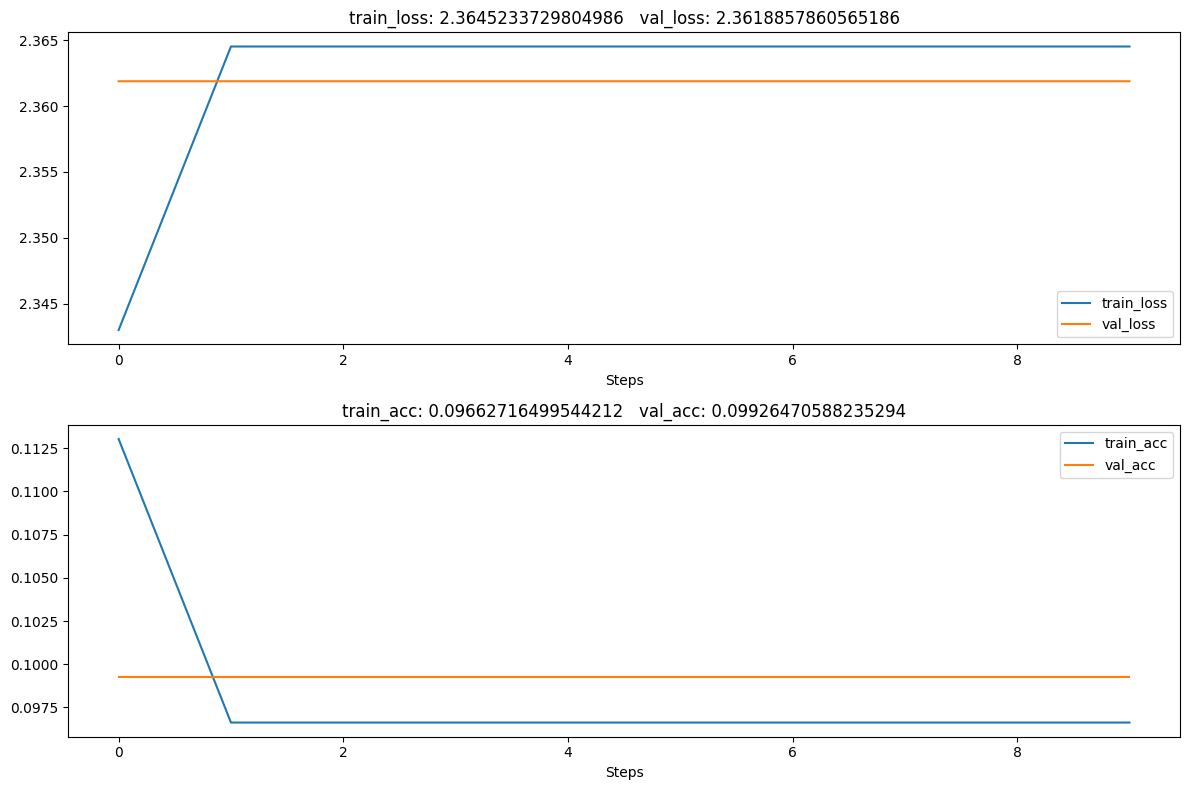

In [11]:
# 对模型进行迭代训练对所有的数据训练epoch轮
for epoch in range(10):
    train_loss_epoch = 0
    val_loss_epoch = 0
    train_corrects = 0
    val_corrects = 0
    
    # 对训练数据的加载器进行迭代计算
    Myvggc.train()
    for step, (b_x, b_y) in enumerate(train_data_loader):
        # 计算每个batch的损失
        output = Myvggc(b_x)
        loss = loss_func(output, b_y)
        pre_lab = torch.argmax(output, 1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * b_x.size(0)
        train_corrects += torch.sum(pre_lab==b_y.data)
        
    # 计算一个epoch的损失和精度
    train_loss = train_loss_epoch / len(train_data.targets)
    train_acc = train_corrects.double() / len(train_data.targets)
    
    # 计算在验证集上的表现
    Myvggc.eval()
    for step, (val_x, val_y) in enumerate(val_data_loader):
        # 计算每个batch的损失
        output = Myvggc(val_x)
        loss = loss_func(output, val_y)
        pre_lab = torch.argmax(output, 1)
        val_loss_epoch += loss.item() * val_x.size(0)
        val_corrects += torch.sum(pre_lab==val_y.data)
        
    # 计算一个epoch的损失和精度
    val_loss = val_loss_epoch / len(val_data.targets)
    val_acc = val_corrects.double() / len(val_data.targets)
    
    # 保存每个epoch上的输出loss和acc
    history1.log(epoch, train_loss=train_loss,
                val_loss=val_loss,
                train_acc=train_acc.item(),
                val_acc=val_acc.item(),
                )
    
    # 可视化网络训练的过程
    with canvas1:
        canvas1.draw_plot([history1['train_loss'], history1['val_loss']])
        canvas1.draw_plot([history1['train_acc'], history1['val_acc']])